In [209]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import cmcrameri.cm as cm
import time
from skimage.data import binary_blobs

import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fftn, ifftn, fftshift, ifftshift

from torchdiffeq import odeint, odeint_adjoint

from utils import cm, format_axis, props
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim

from utils import cm, format_axis, props
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

In [2]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
default_type = torch.float64
torch.set_default_dtype(default_type)

In [3]:
method = 'dopri5'
adjoint = False

In [37]:
import sys, importlib
importlib.reload(sys.modules['cxs'])
importlib.reload(sys.modules['ode'])
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

### Kuramoto

In [62]:
args = {'N': 100,
        'L': 2.,
        'v': 0.5,
        'K': 0.2
       }
M = 100

kuramoto = Kuramoto(args, method, default_type)
kuramoto.init_state(M)
kuramoto.to(device)

tf = 75
T = 151
t = torch.linspace(0, tf, T)
t0 = 50
T -= t0

kuramoto.solve(t, device=device)
kuramoto.trim(t0)

Elapsed time: 1.02 s


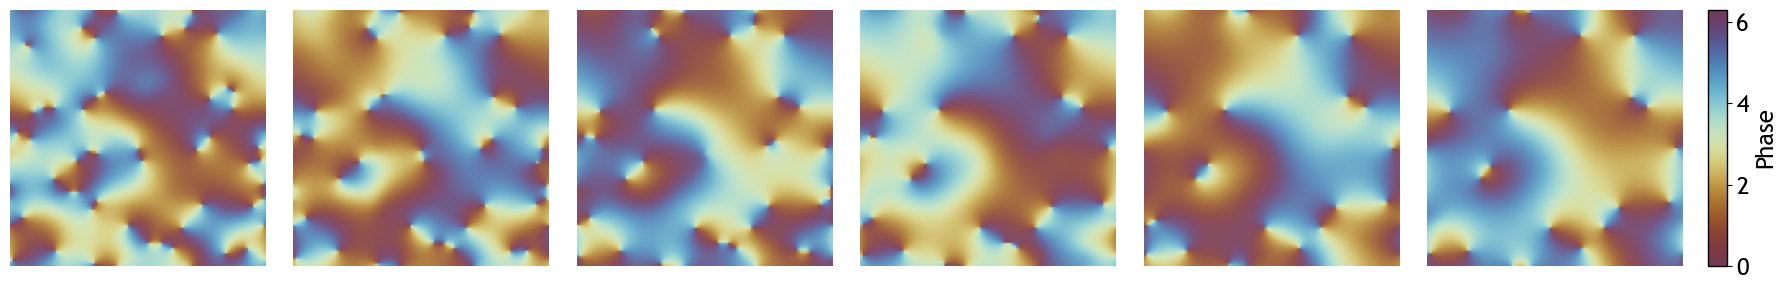

In [66]:
fig = kuramoto.plot_series(kuramoto.y[:,0].reshape(-1,kuramoto.N,kuramoto.N), ntype='mod', clabel='Phase')

### Gray-Scott

In [67]:
args = {'N': 200,
        'L': 2.,
        'Du': 1e-5,
        'Dv': 5e-6,
        'f': 0.040,
        'k': 0.063,
        'f0': 0.040,
        'k0': 0.060
       }
M = 100

grayscott = GrayScott(args, method, default_type)
grayscott.init_state(M)
grayscott.to(device)

tf = 2500
T = 6
t = torch.linspace(0, tf, T)

grayscott.init_solve(t)

Elapsed time: 3.53 s


In [68]:
tf = 250
T = 51
t = torch.linspace(0, tf, T)

grayscott.solve(t, device=device)

Elapsed time: 0.44 s


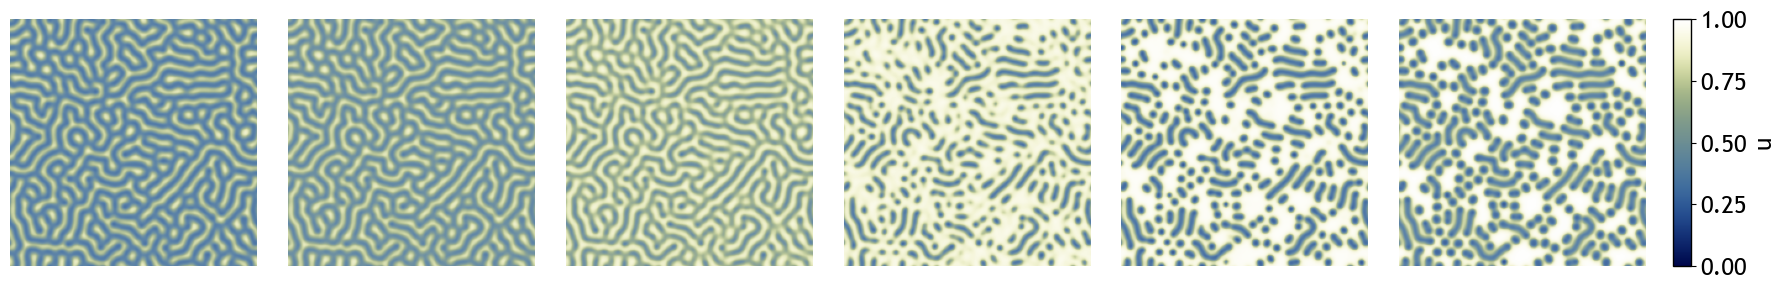

In [69]:
fig = grayscott.plot_series(grayscott.y[:,0,0].reshape(-1,grayscott.N,grayscott.N), ntype='unit', clabel='u')

### Lotka-Volterra

In [49]:
args = {'N': 400,
        'L': 2.,
        'R': 0.07,
        'alpha': 1./3,
        'beta': 2./3,
        'gamma': 0.5,
        'delta': 0.5
       }
M = 100

lv = LotkaVolterra(args, method, default_type)
lv.init_state(M)
lv.to(device)

tf = 100
T = 51
t = torch.linspace(0, tf, T)

lv.solve(t, device=device)

Elapsed time: 7.54 s


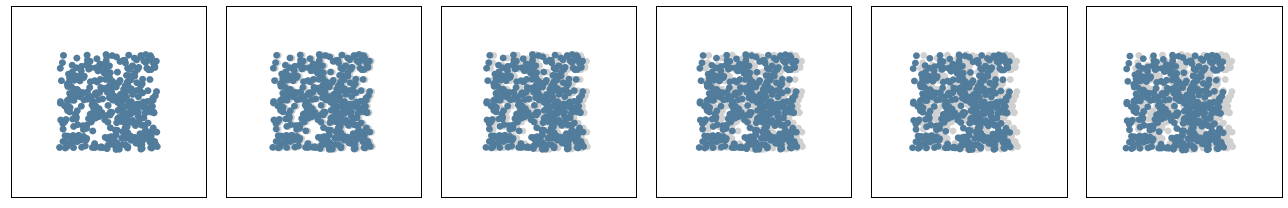

In [53]:
fig = lv.plot_series(lv.y[:,0], ntype='none')

### Kuramoto

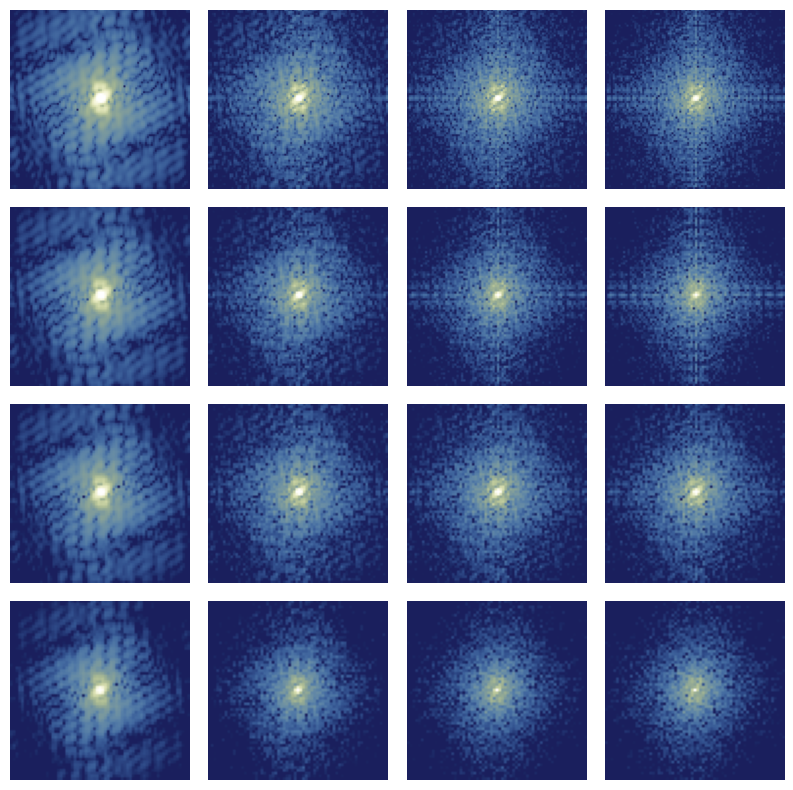

In [108]:
n = 64
f_mask = None
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):
        cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
        kuramoto.plot_frame(ax[i,j], cxs(kuramoto.y0[0], pol=1).reshape(cxs.n, cxs.n),
                            vmin=1e2, vmax=1e8, ntype='log')

Detector: 80 x 80 	Probe: 13 x 13


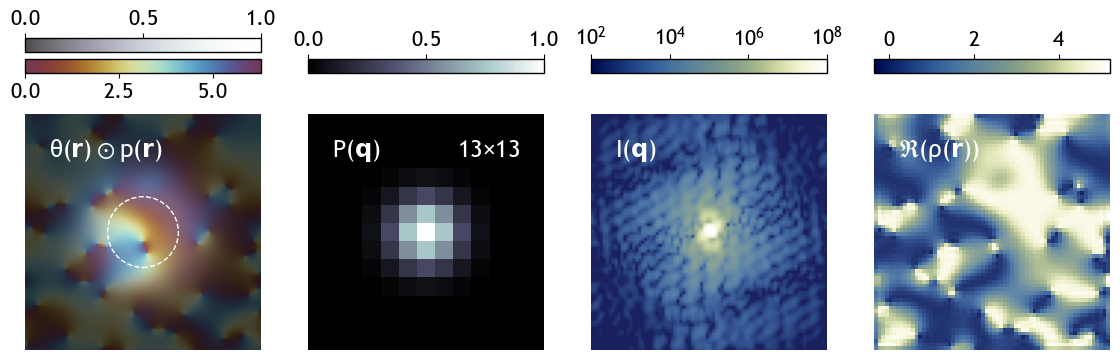

In [109]:
n = 64
dq = 0.8
f_probe = 0.15
f_mask = None
cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
cxs.shapes()
fig = cxs.plot_example(kuramoto, kuramoto.y0[0], ntype='mod', vmin=1e2, vmax=1e8)

In [76]:
batch_time = 20
batch_size = 10
t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch, pol=1)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([20])
y0: torch.Size([10, 1, 10000])
 y: torch.Size([20, 10, 1, 10000])
Elapsed time: 0.001 s


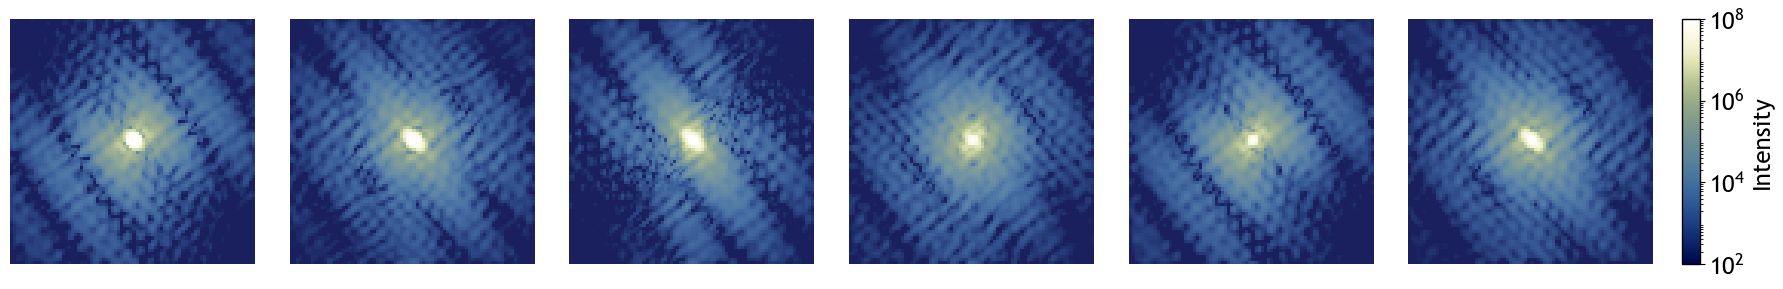

In [77]:
fig = kuramoto.plot_series(Y_batch[:,0].reshape(-1,cxs.n,cxs.n), ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity')

### Gray-Scott

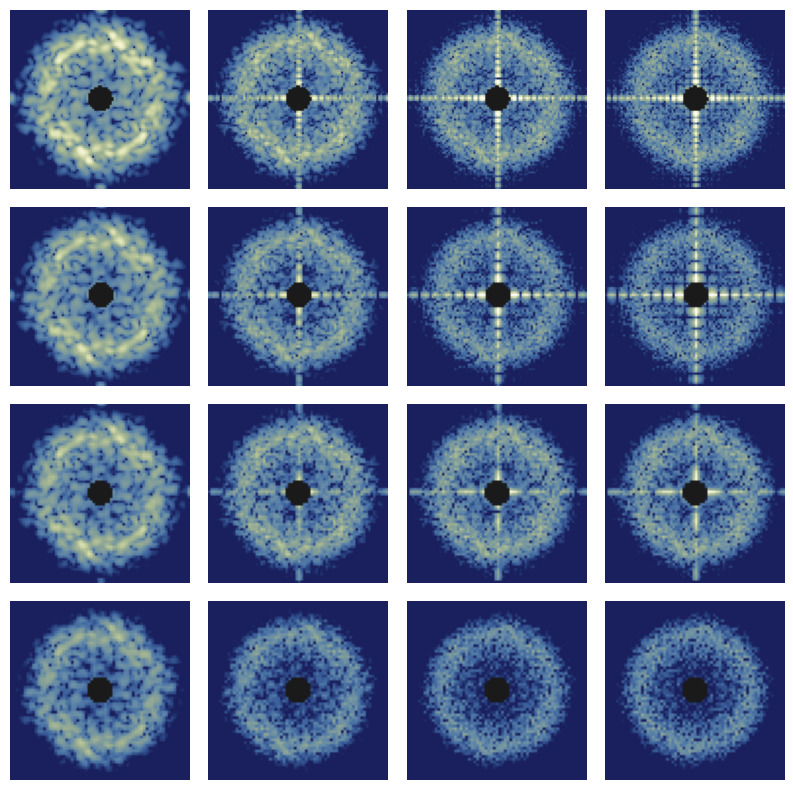

In [78]:
n = 64
f_mask = 0.07
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):     
        cxs = CXSGrid(grayscott.N, n, L=grayscott.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='unit').to(device)
        grayscott.plot_frame(ax[i,j], cxs(grayscott.y0[0], pol=1).reshape(cxs.n, cxs.n),
                             vmin=1e2, vmax=1e6, ntype='log')

Detector: 80 x 80 	Probe: 13 x 13


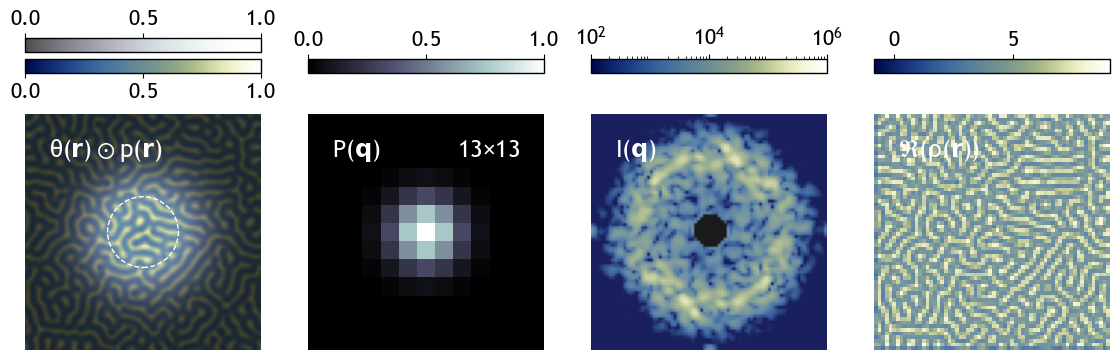

In [79]:
n = 64
dq = 0.8
f_probe = 0.15
f_mask = 0.07
cxs = CXSGrid(grayscott.N, n, L=grayscott.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='unit').to(device)
cxs.shapes()
fig = cxs.plot_example(grayscott, grayscott.y0[0], ntype='unit', vmin=1e2, vmax=1e6)

In [80]:
batch_time = 20
batch_size = 10
t_batch, y0_batch, y_batch = grayscott.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch, pol=1)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([20])
y0: torch.Size([10, 2, 40000])
 y: torch.Size([20, 10, 2, 40000])
Elapsed time: 0.001 s


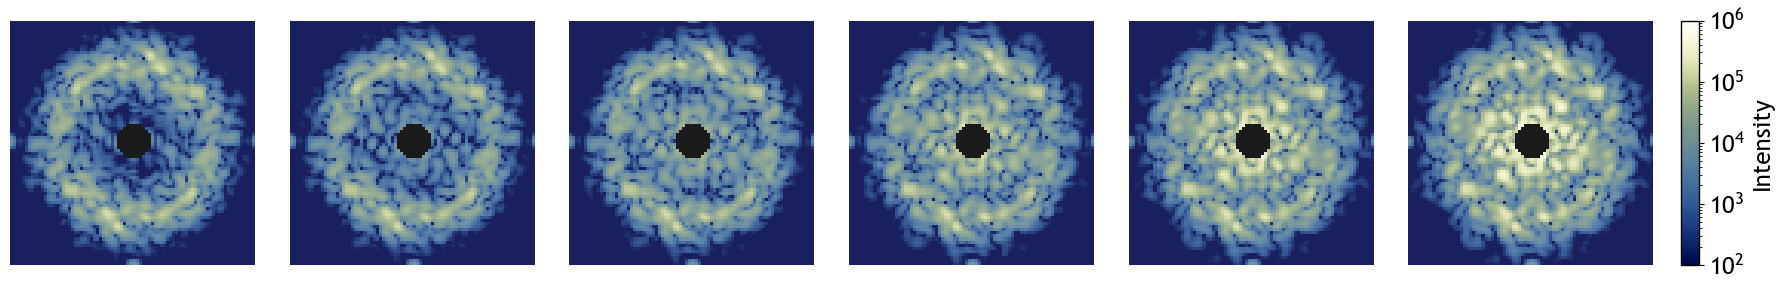

In [81]:
fig = grayscott.plot_series(Y_batch[:,0].reshape(-1,cxs.n,cxs.n), ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity')

### Lotka-Volterra

/Users/ninaandrejevic/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:885.)
  return F.conv2d(input, weight, bias, self.stride,


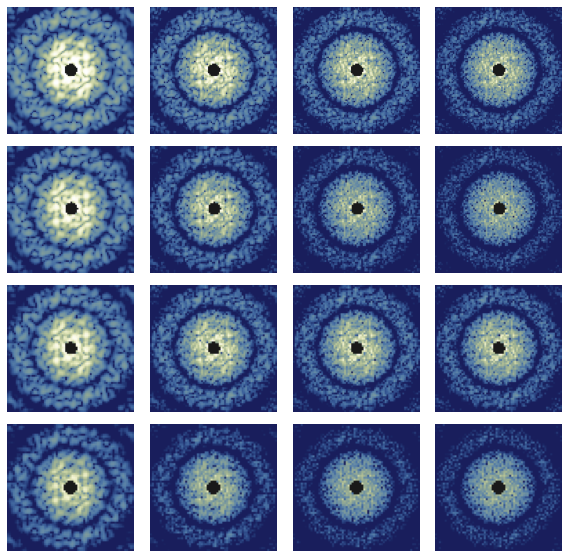

In [7]:
n = 64
f_mask = 0.05
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):     
        cxs = CXSPoint(lv.R, n, L=lv.L, dq=dq, f_probe=f_probe, f_mask=f_mask).to(device)
        lv.plot_frame(ax[i,j], cxs(lv.y0[0]).reshape(cxs.n, cxs.n), vmin=1, vmax=1e4, ntype='log')

Detector: 48 x 48 	Probe: 11 x 11


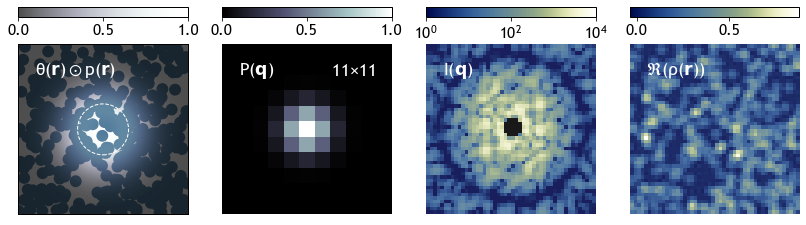

In [8]:
n = 48
dq = 1.
f_probe = 0.15
f_mask = 0.05
cxs = CXSPoint(lv.R, n, L=lv.L, dq=dq, f_probe=f_probe, f_mask=f_mask).to(device)
cxs.shapes()
fig = cxs.plot_example(lv, lv.y0[0], vmin=1, vmax=1e4)

In [9]:
batch_time = 20
batch_size = 10
t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([10])
y0: torch.Size([10, 400, 2])
 y: torch.Size([10, 10, 400, 2])
Elapsed time: 0.504 s


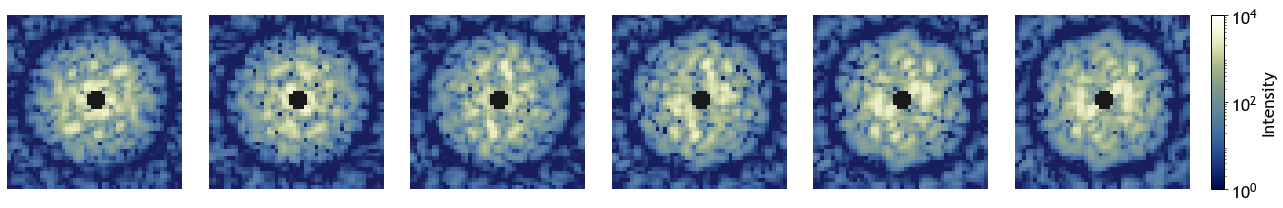

In [10]:
fig = lv.plot_series(Y_batch[:,0].reshape(-1,cxs.n,cxs.n), ntype='log', vmin=1, vmax=1e4, clabel='Intensity');

### Kuramoto

In [359]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True)
        
        default_args = {'N': 100,
                        'L': 2.,
                        'v': 0.5,
                        'K': 0.2,
                        'n': 64,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.cxs = CXSGrid(self.N, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask, f='phase')
        
        self.conv = nn.Conv2d(1, 1, 5, bias=False, padding='same', padding_mode='circular')
        nn.init.normal_(self.conv.weight, mean=0, std=0.1)
    
    
    def loss(self, y_true, y_pred, pol=1):
        return nn.L1Loss()(self.cxs(y_true, pol), self.cxs(y_pred, pol))
        
        
    def forward(self, t, y):
        y = y.view((-1, 1, self.N, self.N))
        cosy = torch.cos(y)
        siny = torch.sin(y)
        conv_cosy = self.conv(cosy)
        conv_siny = self.conv(siny)
        return self.v + self.K*(cosy*conv_siny - siny*conv_cosy).flatten(start_dim=-2)

In [123]:
method = 'dopri5'
adjoint = False
args = {'N': 100,
        'L': 2.,
        'v': 0.5,
        'K': 0.2,
        'n': 64,
        'dq': 0.8,
        'f_probe': 0.15,
        'f_mask': None,
       }

node = NODE(args, method, adjoint, default_type).to(device)
node.cxs.shapes()
optimizer = optim.Adam(node.parameters(), lr=1e-2)
print(node)

NODE(
  (cxs): CXSGrid(
    (probe): Conv2d(1, 1, kernel_size=(64, 64), stride=(1, 1), padding=same, bias=False)
  )
  (conv): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)


In [124]:
max_iters = 100
chkpt = 5
batch_time = 20
batch_size = 10

end = time.time()
loss = []
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_batch, y_pred)
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.6f} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))

    end = time.time()

Iteration: 0005 | Total Loss: 11205.888215 | Time: 0.670522
Iteration: 0010 | Total Loss: 12434.697451 | Time: 0.674222
Iteration: 0015 | Total Loss: 13217.373627 | Time: 0.674361
Iteration: 0020 | Total Loss: 10693.069678 | Time: 0.674185
Iteration: 0025 | Total Loss: 9954.904281 | Time: 0.674106
Iteration: 0030 | Total Loss: 7785.307278 | Time: 0.674296
Iteration: 0035 | Total Loss: 9066.498563 | Time: 0.714980
Iteration: 0040 | Total Loss: 7441.963102 | Time: 0.755901
Iteration: 0045 | Total Loss: 6242.341341 | Time: 0.800626
Iteration: 0050 | Total Loss: 5555.250773 | Time: 0.837543
Iteration: 0055 | Total Loss: 4514.975823 | Time: 0.837506
Iteration: 0060 | Total Loss: 2565.622359 | Time: 0.878333
Iteration: 0065 | Total Loss: 3424.853108 | Time: 0.922918
Iteration: 0070 | Total Loss: 3243.993494 | Time: 0.918885
Iteration: 0075 | Total Loss: 1938.401362 | Time: 0.918826
Iteration: 0080 | Total Loss: 1470.306989 | Time: 0.959535
Iteration: 0085 | Total Loss: 1760.532404 | Time: 1.

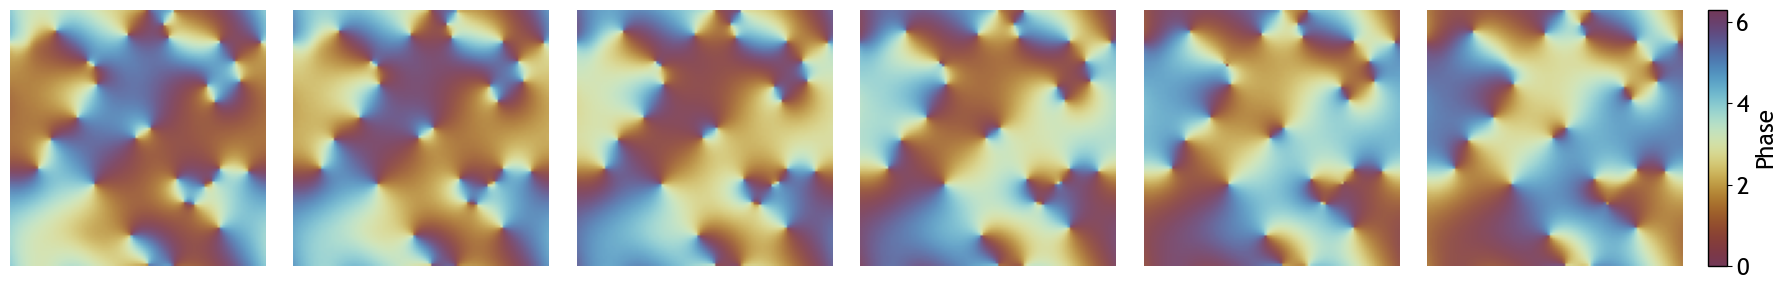

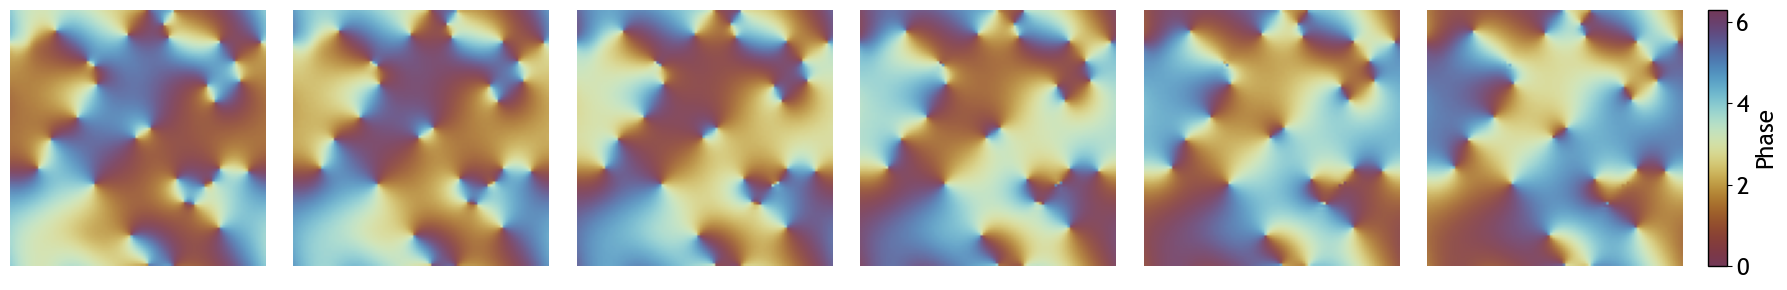

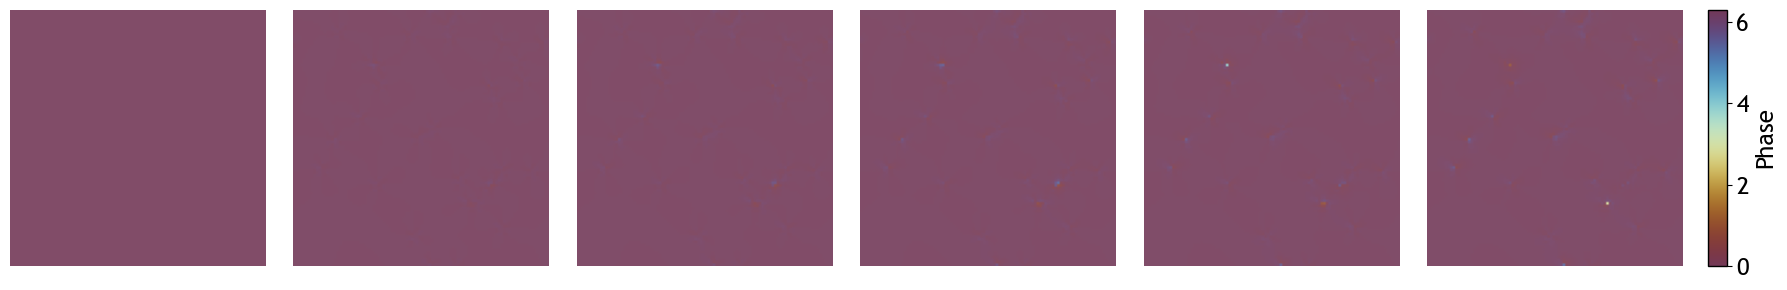

In [125]:
t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
y_pred = node.solve(t_batch, y0_batch, device)

fig = node.plot_series(y_batch[:,0].detach().reshape(-1,node.N,node.N), ntype='mod', clabel='Phase')
fig = node.plot_series(y_pred[:,0].detach().reshape(-1,node.N,node.N), ntype='mod', clabel='Phase')

diff = y_pred[:,0] - y_batch[:,0]
fig = node.plot_series(diff.detach().reshape(-1,node.N,node.N), ntype='mod', clabel='Phase')

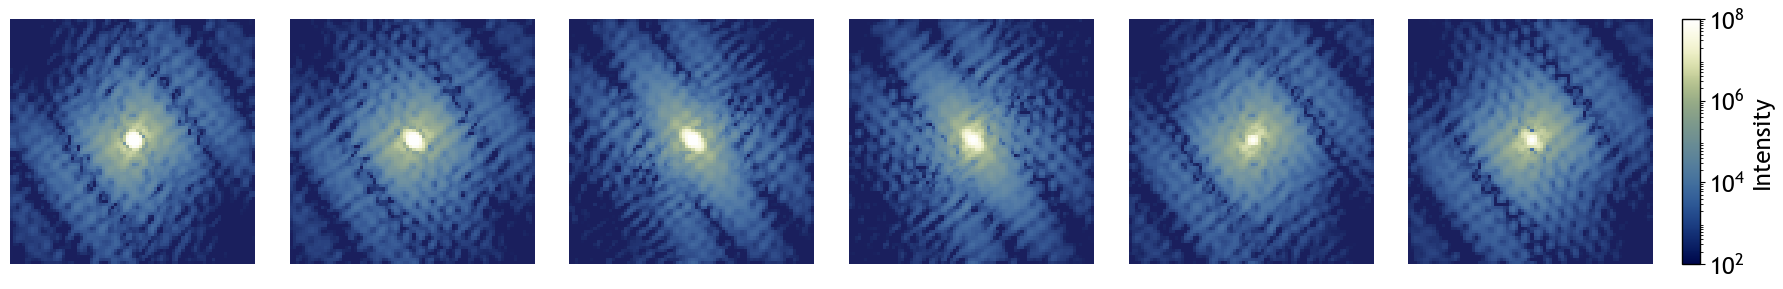

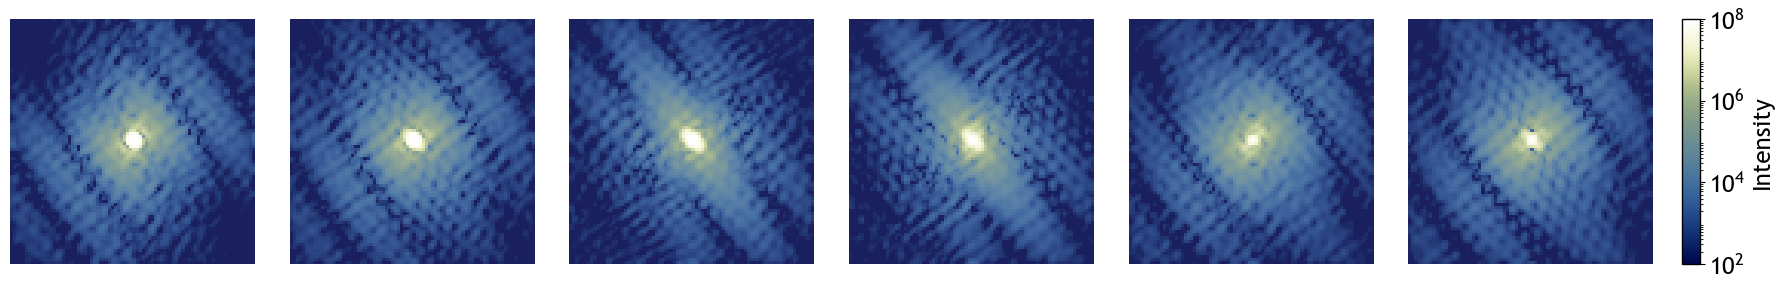

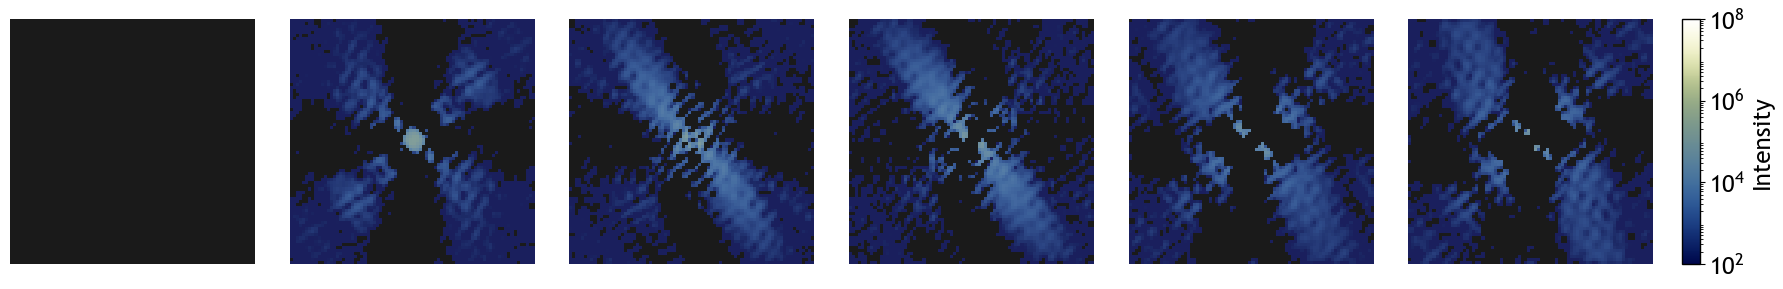

In [126]:
with torch.no_grad():
    fig = node.plot_series(node.cxs(y_batch[:,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity')
    fig = node.plot_series(node.cxs(y_pred[:,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity')
    
    diff = node.cxs(y_pred[:,0]) - node.cxs(y_batch[:,0])
    fig = node.plot_series(diff.reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity')

### Lotka-Volterra

In [65]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True)
        
        default_args = {'L': 2.,
                        'R': 0.05,
                        'n': 64,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.cxs = CXSPoint(self.R, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask)
        
        #self.A = nn.Linear(2,2)

        self.F = nn.Sequential(
            nn.Linear(2,10),
            nn.Tanh(),
            nn.Linear(10,2)
        )
                
    
    def loss(self, y_true, y_pred):
        return nn.L1Loss()(self.cxs(y_true), self.cxs(y_pred))
        
        
    def forward(self, t, y):
        N = y.shape[-2]
        y_mean = y.mean(dim=-2, keepdims=True)
        dy = self.F(y_mean) #+self.A(y_mean)
        return torch.tile(dy, (1, N, 1))

In [66]:
method = 'dopri5'
adjoint = False
args = {'L': 2.,
        'R': 0.07,
        'n': 32,
        'dq': 0.5,
        'f_probe': 0.2,
        'f_mask': 0.05,
       }

node = NODE(args, method, adjoint, default_type).to(device)
node.cxs.shapes()
optimizer = optim.Adam(node.parameters(), lr=1e-2)
print(node)

Detector: 64 x 64 	Probe: 15 x 15
NODE(
  (cxs): CXSPoint(
    (probe): Conv2d(1, 1, kernel_size=(32, 32), stride=(1, 1), padding=same, bias=False)
  )
  (F): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [67]:
t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
print(torch.cat((lv(t_batch, y_batch)[:,3,0], node(t_batch, y_batch)[:,3,0]), dim=-1))

tensor([[-0.3643,  0.0413,  0.2162, -0.0967],
        [-0.1275, -0.1659,  0.1654, -0.1973],
        [-0.0024, -0.1312,  0.1735, -0.2071],
        [ 0.0702, -0.0692,  0.1973, -0.1885],
        [ 0.1441, -0.0255,  0.2309, -0.1524],
        [ 0.2239,  0.0138,  0.2763, -0.0850],
        [ 0.2186,  0.0904,  0.3216,  0.0238],
        [-0.1458,  0.2363,  0.3174,  0.0653],
        [-0.3708,  0.0548,  0.2199, -0.0903],
        [-0.1346, -0.1643,  0.1658, -0.1957]], grad_fn=<CatBackward0>)


In [143]:
max_iters = 50
chkpt = 2
batch_time = 20
batch_size = 10

end = time.time()
loss = []
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_batch, y_pred)
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.6f} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))

    end = time.time()

Iteration: 0002 | Total Loss: 861.096603 | Time: 7.132661
Iteration: 0004 | Total Loss: 745.016137 | Time: 6.793922
Iteration: 0006 | Total Loss: 776.996662 | Time: 6.530881
Iteration: 0008 | Total Loss: 837.832835 | Time: 6.482140
Iteration: 0010 | Total Loss: 814.611977 | Time: 7.040656
Iteration: 0012 | Total Loss: 765.578275 | Time: 7.160203
Iteration: 0014 | Total Loss: 832.824612 | Time: 6.316053
Iteration: 0016 | Total Loss: 992.930966 | Time: 6.327744
Iteration: 0018 | Total Loss: 635.656999 | Time: 6.322527
Iteration: 0020 | Total Loss: 821.014947 | Time: 6.842822
Iteration: 0022 | Total Loss: 693.626039 | Time: 6.378145
Iteration: 0024 | Total Loss: 761.873554 | Time: 6.318626
Iteration: 0026 | Total Loss: 821.500749 | Time: 6.198331
Iteration: 0028 | Total Loss: 875.708430 | Time: 6.305333
Iteration: 0030 | Total Loss: 777.127367 | Time: 6.837210
Iteration: 0032 | Total Loss: 979.257806 | Time: 6.267968
Iteration: 0034 | Total Loss: 867.507733 | Time: 6.256068


KeyboardInterrupt: 

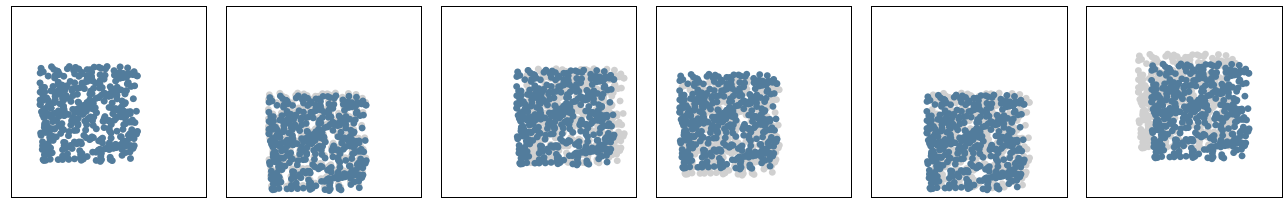

In [146]:
with torch.no_grad():
    t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    fig = node.plot_series([y_batch[:,0], y_pred[:,0].detach()], ntype='none')

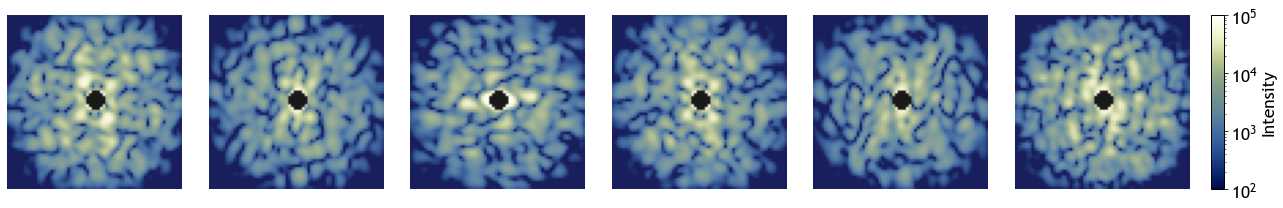

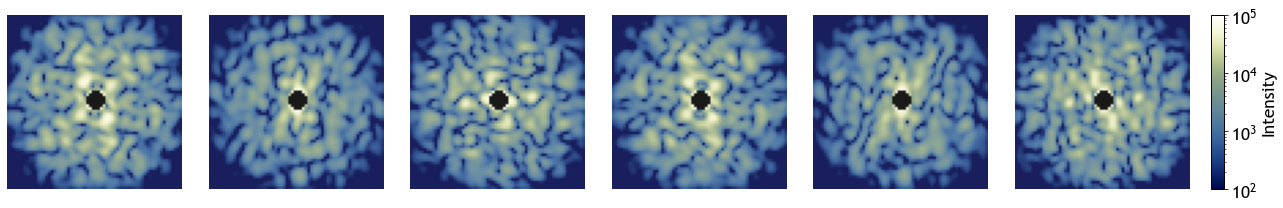

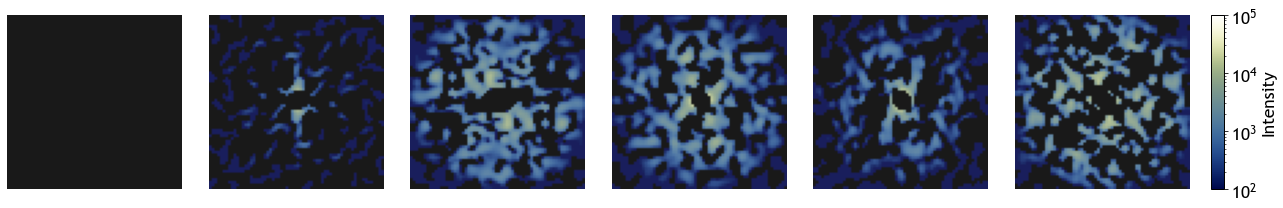

In [147]:
with torch.no_grad():
    fig = node.plot_series(node.cxs(y_batch[:,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e5, clabel='Intensity')
    fig = node.plot_series(node.cxs(y_pred[:,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e5, clabel='Intensity')
    
    diff = node.cxs(y_pred[:,0]) - node.cxs(y_batch[:,0])
    fig = node.plot_series(diff.reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e5, clabel='Intensity')

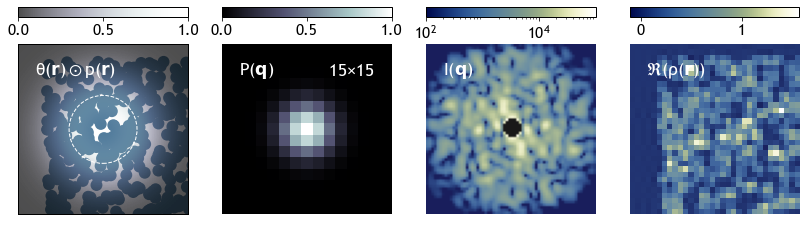

In [148]:
fig = node.cxs.plot_example(node, y_pred[5*(batch_time//6),0].detach(), vmin=1e2, vmax=1e5)